**Imports**

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy.spatial.distance import cdist

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:

tf.__version__

'2.15.0'

In [5]:
import keras
print(keras.__version__)

2.15.0


**Load Data**

In [6]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.9/170.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.3.1
    Uninstalling fsspec-2024.3.1:
      Successfully uninstalled fsspec-2024.3.1
Note: you may need to restart the kernel to use updated packages.


In [7]:
from datasets import load_dataset

In [8]:
dataset = load_dataset('stanfordnlp/imdb')

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [9]:
x_train_text = dataset['train']['text']
y_train  = dataset['train']['label']

x_test_text = dataset['test']['text']
y_test  = dataset['test']['label']

In [10]:
# Convert to numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)

In [11]:
print('Train-set size: ', len(x_train_text))
print('Test-set size: ', len(x_test_text))

Train-set size:  25000
Test-set size:  25000


In [12]:
# Combine into one dataset for vocab creation
data_text = x_train_text + x_test_text

In [13]:
x_train_text[0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [14]:
# 0: Negative Sentiment, 1: Positive Sentiment
y_train[1]

0

**Tokenizer**

In [15]:
# Instructing the Tokenizer to use 10000 most popular words from the dataset
num_words = 10000

In [16]:
tokenizer = Tokenizer(num_words = num_words)

In [17]:
%%time
tokenizer.fit_on_texts(data_text)

CPU times: user 8.08 s, sys: 47.9 ms, total: 8.12 s
Wall time: 8.12 s


In [18]:
tokenizer.word_index

{'the': 1,
 'and': 2,
 'a': 3,
 'of': 4,
 'to': 5,
 'is': 6,
 'br': 7,
 'in': 8,
 'it': 9,
 'i': 10,
 'this': 11,
 'that': 12,
 'was': 13,
 'as': 14,
 'for': 15,
 'with': 16,
 'movie': 17,
 'but': 18,
 'film': 19,
 'on': 20,
 'not': 21,
 'you': 22,
 'are': 23,
 'his': 24,
 'have': 25,
 'be': 26,
 'one': 27,
 'he': 28,
 'all': 29,
 'at': 30,
 'by': 31,
 'an': 32,
 'they': 33,
 'so': 34,
 'who': 35,
 'from': 36,
 'like': 37,
 'or': 38,
 'just': 39,
 'her': 40,
 'out': 41,
 'about': 42,
 'if': 43,
 "it's": 44,
 'has': 45,
 'there': 46,
 'some': 47,
 'what': 48,
 'good': 49,
 'when': 50,
 'more': 51,
 'very': 52,
 'up': 53,
 'no': 54,
 'time': 55,
 'my': 56,
 'even': 57,
 'would': 58,
 'she': 59,
 'which': 60,
 'only': 61,
 'really': 62,
 'see': 63,
 'story': 64,
 'their': 65,
 'had': 66,
 'can': 67,
 'me': 68,
 'well': 69,
 'were': 70,
 'than': 71,
 'much': 72,
 'we': 73,
 'bad': 74,
 'been': 75,
 'get': 76,
 'do': 77,
 'great': 78,
 'other': 79,
 'will': 80,
 'also': 81,
 'into': 82,
 'p

In [19]:
# Convert all texts in training set to list of tokens
x_train_tokens = tokenizer.texts_to_sequences(x_train_text)

In [20]:
x_train_text[0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [21]:
np.array(x_train_tokens[0])

array([  10, 1567,   10,  235, 2119, 3956,   36,   56,  373, 1088,   84,
          4,   29,    1, 6340,   12, 3611,    9,   50,    9,   13,   86,
        613,    8, 7540,   10,   81,  554,   12,   30,   86,    9,   13,
         31, 1153,  580, 9106,   43,    9,  123,  762,    5, 2320,   11,
        679, 1548,  109,    3,  326,    4,  104, 1228, 2924,   10,   62,
         66,    5,   63,   11,   15,  538,    7,    7,    1,  111,    6,
       4133,  183,    3,  186, 3655,  449, 1425,  770, 5973,   35,  487,
          5,  854,  267,   59,   67,   42,  114,    8,  865,   59,  487,
          5, 1151,   40,    5,  232,   47,  430,    4,  640,   20,   48,
          1,  848,  190,   42,  764,  991, 1262,  138,   14,    1, 2421,
        295,    2, 1394, 1262,    8,    1, 2249, 1652,    8,  201, 2196,
       6088,    2, 1877,    4,   42,   65, 3971,   20, 2531,   59,   45,
        376,   16,   40,  449, 1664, 9498,    2, 1062,  345,    7,    7,
         48, 1164,   68,   42,   10,  235, 2119, 39

In [22]:
# Convert all texts in test set to a list of tokens
x_test_tokens = tokenizer.texts_to_sequences(x_test_text)

**Padding and Truncating**

In [23]:
# Count number of tokens in all the sequences in the dataset
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

In [24]:
# the average number of tokens in a sequence is
np.mean(num_tokens)

221.27716

In [25]:
# the maximum number of tokens in a sequence is
np.max(num_tokens)

2209

In [26]:
# the max number of tokens we wil allow is set to average + 2 std.
max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

544

In [27]:
# This covers about 95% of the dataset
np.sum(num_tokens < max_tokens)/len(num_tokens)

0.94534

In [28]:
pad = 'pre'

In [29]:
x_train_pad = pad_sequences(x_train_tokens, maxlen = max_tokens, padding = pad, truncating = pad)

In [30]:
x_test_pad = pad_sequences(x_train_tokens, maxlen = max_tokens, padding = pad, truncating = pad)

In [31]:
x_train_pad.shape

(25000, 544)

In [32]:
x_test_pad.shape

(25000, 544)

In [33]:
np.array(x_train_tokens[1])

array([  10,  235, 2119, 3956,    6,    3,    2, 2123, 8306, 2623,    9,
        149,  504,   48, 1998,  991, 2791,   23,   84,   11,   19,   67,
       1031,   26,  607,  612,   20,   99,  652,   14,   15,    1, 2425,
         12, 6813,  910, 1042,    6,   32, 8370, 2962,   12,  213,  289,
        198,  107, 1464, 1196,  104,   16,  910, 1042, 2469,   33,   61,
       1454,   47, 9107, 2791,   18,  117,   23,    1, 1464, 1196,  104,
         16,    2, 1272,   84,   33,   89, 1874,    1,  167,  269,   15,
        143, 1940, 1897,  276, 7060,    8,    1,   18,   21,    3,    8,
       1680,    2,  143, 2123, 2700,   97,   37,    1, 1882, 5596,    8,
         60, 1057, 1884,    5,    1, 2060,    4, 2977, 2638,   18,   21,
          3, 6418,    4, 3668, 4910,   20, 9108,  159, 2492,   38, 1428,
       1267,    8, 2282,    4, 1042,    1, 2917,  142,  187,   82, 2624,
         27,  595, 1497,  201,  345,    2,  378,   46,   23,   54,   20,
       2434,   50, 1530,  733, 2784,    2,    1,  1

In [34]:
x_train_pad[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

**Tokenizer Inverse Map**

In [35]:
idx  = tokenizer.word_index
inverse_map = dict(zip(idx.values(),idx.keys()))

In [36]:
def tokens_to_strings(tokens):
  sentence = ""
  for token in tokens:
    if token != 0:
      sentence += inverse_map[token]+" "
  return sentence

In [37]:
x_train_text[1]

'"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn\'t matter what one\'s political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn\'t true. I\'ve seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don\'t exist. The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight. And those pretentious indie movies like The Brown Bunny, in which we\'re treated to the site of Vincent Gallo\'s throbbing johnson, but not a trace of pink visible on Chloe Sevigny. Before crying (or implying) "double-standard" in matters of nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nude, and the s

In [38]:
tokens_to_strings(x_train_tokens[1])

"i am curious yellow is a and pretentious steaming pile it doesn't matter what one's political views are because this film can hardly be taken seriously on any level as for the claim that frontal male nudity is an automatic 17 that isn't true i've seen r rated films with male nudity granted they only offer some fleeting views but where are the r rated films with and nowhere because they don't exist the same goes for those crappy cable shows swinging in the but not a in sight and those pretentious indie movies like the brown bunny in which we're treated to the site of vincent johnson but not a trace of pink visible on chloe before crying or double standard in matters of nudity the mentally should take into account one obvious difference between men and women there are no on display when actresses appears nude and the same cannot be said for a man in fact you generally won't see female in an american film in anything short of porn or explicit this alleged double standard is less a double

**Create the Neural Network**

In [40]:
model = Sequential()

In [38]:
embedding_size = 8

In [39]:
model.add(Embedding(input_dim = num_words, output_dim = embedding_size, input_length = max_tokens, name = 'layer_embedding'))

In [40]:
model.add(GRU(units = 16, return_sequences = True))

In [41]:
model.add(GRU(units = 8, return_sequences = True))

In [42]:
model.add(GRU(units =4 ))

In [43]:
model.add(Dense(1, activation = 'sigmoid'))

In [44]:
optimizer = Adam(learning_rate = 1e-3)

In [45]:
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

In [46]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_embedding (Embedding  (None, 544, 8)            80000     
 )                                                               
                                                                 
 gru (GRU)                   (None, 544, 16)           1248      
                                                                 
 gru_1 (GRU)                 (None, 544, 8)            624       
                                                                 
 gru_2 (GRU)                 (None, 4)                 168       
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 82045 (320.49 KB)
Trainable params: 82045 (320.49 KB)
Non-trainable params: 0 (0.00 Byte)
__________________

**Train the Reccurent Neural Network**

In [47]:
%%time
model.fit(x_train_pad, y_train, validation_split = 0.05, epochs = 3, batch_size = 64)

Epoch 1/3
372/372 [==============================] - 73s 180ms/step - loss: 0.6225 - accuracy: 0.6582 - val_loss: 0.7552 - val_accuracy: 0.0056
Epoch 2/3
372/372 [==============================] - 39s 104ms/step - loss: 0.4336 - accuracy: 0.8201 - val_loss: 0.3015 - val_accuracy: 0.8936
Epoch 3/3
372/372 [==============================] - 30s 81ms/step - loss: 0.2989 - accuracy: 0.8913 - val_loss: 0.2862 - val_accuracy: 0.8952
CPU times: user 1min 47s, sys: 2.62 s, total: 1min 50s
Wall time: 2min 22s


**Performance on Test-Set**

In [48]:
%%time
result = model.evaluate(x_test_pad, y_test)

782/782 [==============================] - 17s 22ms/step - loss: 0.2450 - accuracy: 0.9160
CPU times: user 17 s, sys: 382 ms, total: 17.4 s
Wall time: 20.6 s


In [49]:
print("Accuracy: {0:.2%}".format(result[1]))

Accuracy: 91.60%


**Hyper parameter Optimization**

In [41]:
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
pip install h5py scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 10.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [43]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_histogram, plot_objective_2D
from skopt.utils import use_named_args

In [44]:
# Search dimension for learning rate
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform',
                         name='learning_rate')

In [45]:
# Search dimension for embedding
dim_embeddings_size = Integer(low = 8, high = 300, name = 'embeddings_size')

In [46]:
# Search dimension for GRU1 units
dim_GRU1_units = Integer(low =16, high = 64, name = 'num_GRU1_units' )

In [47]:
# Search dimension for GRU2 units
dim_GRU2_units = Integer(low =8, high = 64, name = 'num_GRU2_units' )

In [48]:
# Search dimension for GRU3 units
dim_GRU3_units = Integer(low =4, high = 64, name = 'num_GRU3_units' )

In [49]:
dimensions = [dim_learning_rate,
              dim_embeddings_size,
              dim_GRU1_units,
              dim_GRU2_units,
              dim_GRU3_units]

In [50]:
default_parameters = [1e-3, 8, 16, 8, 4]

**Helper-function for log-dir-name**

In [51]:
def log_dir_name(learning_rate, embeddings_size,
                 num_GRU1_units, num_GRU2_units, num_GRU3_units):

    # The dir-name for the TensorBoard log-dir.
    s = "./logs/lr_{0:.0e}_embeddins_size_{1}_GRU1_{2}_GRU2_{3}_GRU3_{4}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate,
                       embeddings_size,
                       num_GRU1_units,
                       num_GRU2_units,
                       num_GRU3_units)

    return log_dir

In [52]:
def create_model(learning_rate, embeddings_size, num_GRU1_units, num_GRU2_units, num_GRU3_units):

  model = Sequential()
  model.add(Embedding(input_dim = num_words, output_dim = embeddings_size, input_length = max_tokens, name = 'layer_embedding'))
  model.add(GRU(units = num_GRU1_units, return_sequences = True))
  model.add(Dropout(rate=0.5))  # Add dropout after the first GRU layer
  model.add(GRU(units = num_GRU2_units, return_sequences = True))
  model.add(Dropout(rate=0.5))  # Add dropout after the second GRU layer
  model.add(GRU(units = num_GRU3_units))
  model.add(Dense(1, activation = 'sigmoid'))
  optimizer = Adam(learning_rate = learning_rate)

  model.compile(loss = 'binary_crossentropy',
              optimizer = optimizer,
              metrics = ['accuracy'])

  return model

**Train & Evaluate Model**

In [53]:
path_best_model = 'best_model.h5'

In [54]:
best_accuracy = 0.0

In [55]:
dimensions

[Real(low=1e-06, high=0.01, prior='log-uniform', transform='identity'),
 Integer(low=8, high=300, prior='uniform', transform='identity'),
 Integer(low=16, high=64, prior='uniform', transform='identity'),
 Integer(low=8, high=64, prior='uniform', transform='identity'),
 Integer(low=4, high=64, prior='uniform', transform='identity')]

In [58]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, embeddings_size, num_GRU1_units, num_GRU2_units, num_GRU3_units):

  # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('embeddings_size:', embeddings_size)
    print('num_GRU1_units:', num_GRU1_units)
    print('num_GRU2_units:', num_GRU2_units)
    print('num_GRU3_units:', num_GRU3_units)

    print()

    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate, embeddings_size, num_GRU1_units, num_GRU2_units, num_GRU3_units)

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, embeddings_size,
                 num_GRU1_units, num_GRU2_units, num_GRU3_units)

    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)

    # Define early stopping callback
    #early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

    # Use Keras to train the model.
    history = model.fit(x= x_train_pad,
                        y= y_train,
                        epochs=3,
                        batch_size=64,
                        validation_split = 0.05,
                        callbacks=[callback_log])

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)

        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    K.clear_session()

    return -accuracy

**Run Hyper-Parameter Optimization**

In [59]:
%%time
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=40,
                            x0=default_parameters)

learning rate: 1.0e-03
embeddings_size: 8
num_GRU1_units: 16
num_GRU2_units: 8
num_GRU3_units: 4

Epoch 1/3
372/372 [==============================] - 53s 132ms/step - loss: 0.5672 - accuracy: 0.6926 - val_loss: 0.5470 - val_accuracy: 0.7632
Epoch 2/3
372/372 [==============================] - 32s 85ms/step - loss: 0.3776 - accuracy: 0.8530 - val_loss: 0.3312 - val_accuracy: 0.8728
Epoch 3/3
372/372 [==============================] - 24s 64ms/step - loss: 0.2863 - accuracy: 0.8961 - val_loss: 0.5693 - val_accuracy: 0.7520

Accuracy: 75.20%

learning rate: 7.2e-06
embeddings_size: 35
num_GRU1_units: 48
num_GRU2_units: 51
num_GRU3_units: 27



/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/3
372/372 [==============================] - 61s 153ms/step - loss: 0.6928 - accuracy: 0.5218 - val_loss: 0.7042 - val_accuracy: 0.0000e+00
Epoch 2/3
372/372 [==============================] - 37s 99ms/step - loss: 0.6922 - accuracy: 0.5265 - val_loss: 0.7137 - val_accuracy: 0.0000e+00
Epoch 3/3
372/372 [==============================] - 28s 75ms/step - loss: 0.6917 - accuracy: 0.5264 - val_loss: 0.7225 - val_accuracy: 0.0000e+00

Accuracy: 0.00%

learning rate: 5.8e-03
embeddings_size: 16
num_GRU1_units: 21
num_GRU2_units: 57
num_GRU3_units: 41

Epoch 1/3
372/372 [==============================] - 56s 141ms/step - loss: 0.4345 - accuracy: 0.7953 - val_loss: 0.7815 - val_accuracy: 0.6560
Epoch 2/3
372/372 [==============================] - 36s 97ms/step - loss: 0.2149 - accuracy: 0.9178 - val_loss: 0.2994 - val_accuracy: 0.8688
Epoch 3/3
372/372 [==============================] - 27s 72ms/step - loss: 0.1261 - accuracy: 0.9579 - val_loss: 0.2643 - val_accuracy: 0.8976

Accuracy

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


learning rate: 1.0e-02
embeddings_size: 300
num_GRU1_units: 37
num_GRU2_units: 64
num_GRU3_units: 4

Epoch 1/3
372/372 [==============================] - 42s 103ms/step - loss: 0.4611 - accuracy: 0.7831 - val_loss: 0.7862 - val_accuracy: 0.6352
Epoch 2/3
372/372 [==============================] - 28s 75ms/step - loss: 0.2983 - accuracy: 0.8792 - val_loss: 0.4391 - val_accuracy: 0.7960
Epoch 3/3
372/372 [==============================] - 24s 63ms/step - loss: 0.2575 - accuracy: 0.9003 - val_loss: 0.8166 - val_accuracy: 0.6120

Accuracy: 61.20%

learning rate: 4.2e-03
embeddings_size: 8
num_GRU1_units: 63
num_GRU2_units: 22
num_GRU3_units: 59

Epoch 1/3
372/372 [==============================] - 42s 104ms/step - loss: 0.5758 - accuracy: 0.6770 - val_loss: 0.8320 - val_accuracy: 0.0000e+00
Epoch 2/3
372/372 [==============================] - 29s 78ms/step - loss: 0.3970 - accuracy: 0.8167 - val_loss: 0.1451 - val_accuracy: 0.9432
Epoch 3/3
372/372 [==============================] - 23s 62

**Optimization Progress**

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

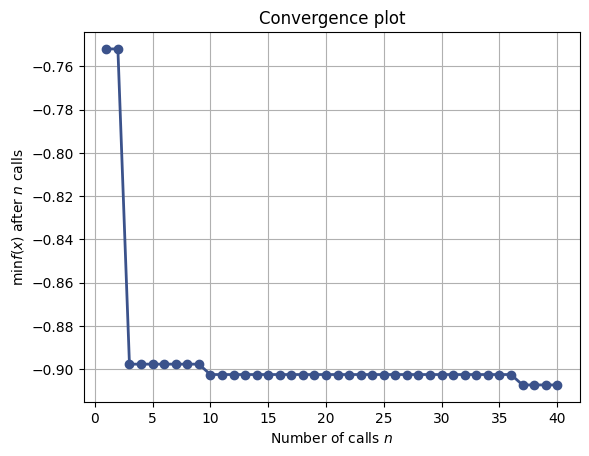

In [60]:
plot_convergence(search_result)

**Best Hyper-Parameters**

In [61]:
search_result.x

[0.01, 8, 38, 64, 4]

In [62]:
space = search_result.space
params_dict = dict(zip(space.dimension_names, search_result.x))
print(params_dict)

{'learning_rate': 0.01, 'embeddings_size': 8, 'num_GRU1_units': 38, 'num_GRU2_units': 64, 'num_GRU3_units': 4}


In [63]:
search_result.fun

-0.9071999788284302

**Evaluate Best Model on Test Set**

In [64]:
model  = load_model(path_best_model)

In [65]:
result = model.evaluate(x = x_test_pad, y = y_test)

782/782 [==============================] - 13s 16ms/step - loss: 0.1605 - accuracy: 0.9522


In [66]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.16048143804073334
accuracy 0.952239990234375


In [67]:
print("Accuracy: {0:.2%}".format(result[1]))

Accuracy: 95.22%
